# Imports

In [1]:
# Make imports
from torch.utils.data import Dataset
import pandas as pd
import glob
import os
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
from torch.nn import functional as F
import matplotlib.pyplot as plt
from sklearn import metrics

# Dataset

In [3]:
# Create "custom" dataset class
class MLProject2Dataset(Dataset):

    def __init__(self, data_dir, metadata_fname='metadata.csv', transform=None) -> None:

        # Set data directory and transform based on parameters pased with object initialization
        self.data_dir = data_dir
        self.transform = transform
        # Create dataframe
        self.df = pd.DataFrame(columns=['image_id', 'path'])
        # Read paths and image filenames
        self.df['image_id'] = [os.path.splitext(os.path.basename(path))[0] for path in glob.glob(f"{self.data_dir}/part_*/*.jpg", recursive = True)]
        self.df['path'] = [absolute_path for absolute_path in glob.glob(f"{self.data_dir}/part_*/*.jpg", recursive = True)]
        # Read metadata from csv file
        metadata = pd.read_csv(f"{data_dir}/{metadata_fname}")
        # Turn string catecorical data into int categorical data
        metadata['dx'] = metadata['dx'].astype('category').cat.codes
        # Merge dataframe containing image paths and names with labels from metadata
        self.df = pd.merge(self.df, metadata[['dx', 'image_id']], on='image_id')

    def __len__(self) -> int:
        # Return dataframe size
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        # Return tuple with image tensor and label
        return (self.transform((torchvision.io.read_image(self.df.iloc[idx].iloc[1]).to(torch.float32)) / 255), self.df.iloc[idx].iloc[2])
        

        

# Train nad test functions

In [4]:
# Define training function
def train_net(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None,
              epochs: int = 10, optimizer: optim = None, loss: nn.modules.loss = None,
              device: str = 'cpu', print_period: int = 10):
    
    """Train model"""
    # Initialize empty arrays for accuracy and loss tracking during training for plots
    accuracy_development_train = []
    accuracy_development_val = []
    loss_development_train = []
    loss_development_val = []

    # Put model in training mode
    model.train()
    # Iterate through epochs
    for epoch in range(epochs):
        # Initialize metrics for loss and accuracy calculation to zero
        print_period_running_loss = 0.0
        total_images = 0
        correct_preds = 0
        
        # Get the training data from the dataloader
        for batch, (X_train, y_train) in enumerate(trainloader, 0):
            # Put data on device (casting the labels to LongTensor is done to eliminate en error occurring during training)
            X_train, y_train = X_train.to(device), y_train.type(torch.LongTensor).to(device)
            # Set gradients to zero
            optimizer.zero_grad()
            # Forward pass (make predictions)
            pred = model(X_train)
            # Get label prediction for training data
            yhat = torch.argmax(pred, 1)
            # Get total number of images in current print period
            total_images += y_train.size(0)
            #Calculate the number of correct predictions made by the model
            correct_preds += (yhat == y_train).type(torch.float).sum().item()
            # Calculate current loss
            current_loss_train = loss(pred, y_train)

            # Perform backpropagation
            current_loss_train.backward()

            # Perform optimizer step
            optimizer.step()

            # Add current loss to running loss
            print_period_running_loss += current_loss_train.item()

            # Check if it's time to print progress
            if batch % print_period == print_period-1:
                
                # Calculate average loss for current print period in training data
                avg_loss_train = print_period_running_loss / print_period
                # Store average loss for current print period for later plot
                loss_development_train.append(avg_loss_train)
                # Print the average loss in training data
                print(f'[Epoch: {epoch}, batch: {batch:5d}] training loss: {avg_loss_train:.5f}')

                # Calculate accuracy for current print period in training data
                accuracy_train = correct_preds / total_images
                # Store accuracy for current print period for later plot
                accuracy_development_train.append(accuracy_train)
                # Print accuracy for current print period in training data
                print(f"Training accuracy in {total_images} images: {accuracy_train:5f}")

                # Set metrics for loss and accuracy calculation to zero for the next print period
                print_period_running_loss = 0
                total_images = 0
                correct_preds = 0
                
                with torch.no_grad():
                    # Set metrics for loss and accuracy calculation to zero
                    validation_loss = 0
                    correct_preds_val = 0
                    # Iterate through validation data
                    for (X_val, y_val) in valloader:

                        # Put data on device (casting the labels to LongTensor is done to eliminate en error occurring during training)
                        X_val, y_val = X_val.to(device), y_val.type(torch.LongTensor).to(device)
                        # Get model predictions for validation data
                        pred_val = model(X_val)
                        # Get label prediction for validation data
                        yhat = torch.argmax(pred_val, 1)
                        # Calculate correct predictions made by the model
                        correct_preds_val += (yhat == y_val).type(torch.float).sum().item()
                        # Get current loss on validation data
                        current_loss_val = loss(pred_val, y_val)
                        # Calculate total validation loss
                        validation_loss += current_loss_val.item()
                        
                    
                    # Calculate average validation loss
                    avg_loss_val = validation_loss / len(valloader)
                    # Store average loss for later plots 
                    loss_development_val.append(avg_loss_val)
                    # Print average validation loss
                    print(f'[Epoch: {epoch}] validation loss: {avg_loss_val:.5f}')

                    # Calculate validation accuracy
                    accuracy_val = correct_preds_val/len(valloader.dataset)
                    # Store accuracy for later plots
                    accuracy_development_val.append(accuracy_val)
                    # Print validation accuracy
                    print(f"Validation accuracy in {len(valloader.dataset)} images: {accuracy_val:5f}")
                    print('\n')
    # Return arrays with accuracy and loss for ploting training progress
    return accuracy_development_train, accuracy_development_val, loss_development_train, loss_development_val
                    

        

In [5]:
# Define testing function
def test_net(model: nn.Module, testloader: DataLoader, loss: nn.modules.loss = None, device: str = 'cpu') -> tuple:
    
    """Test model"""
    # Put model in evaluation mode
    model.eval()
    # Initialize variables for prediction and metric calculation
    y_true = []
    preds = []
    correct = 0
    testing_loss = 0

    with torch.no_grad():
        # Iterate through testing data
        for (X, y) in testloader:
            # Put data on device (casting the labels to LongTensor is done to eliminate en error occurring during training)
            X, y = X.to(device), y.type(torch.LongTensor).to(device)
            # Make predictions with model
            pred = model(X)
            # Get label prediction for validation data
            yhat = torch.argmax(pred, 1)
            # Calculate correct predictions made by the model
            correct += (yhat == y).type(torch.float).sum().item()
            # Get current loss on testing data      
            current_loss = loss(pred, y)
            # Calculate total testing loss
            testing_loss += current_loss.item()
            # Create arrays with true labels and predicted labels for testing data
            y_array = np.array(y)
            y_true = np.concatenate((y_true, y_array), axis=0)
            preds_array = np.array(yhat)
            preds = np.concatenate((preds, preds_array), axis=0)

    # Calculate accuracy
    accuracy_test = correct / len(testloader.dataset)
    # Calculate average testing loss
    avg_loss = testing_loss / len(testloader)
 
    # Return accuracy, loss, true and predicted labels
    return(len(testloader.dataset), accuracy_test, avg_loss, preds, y_true)

# Simple Convolutional network

In [26]:
# Create simple CNN model
class SimpleConv(nn.Module):
    """Simple convolutional neural network"""
    def __init__(self):
        super().__init__()
        # Create three convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        # Create max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Create linear layer 
        self.fc = nn.Linear(1536, 7)

    def forward(self, x):
        # Pass images through convolutional, relu and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the output of previous layers
        x = torch.flatten(x, 1)
        # Pass output through linear layer
        x = self.fc(x)
        # Return output of layers
        return x
    


In [27]:
# Create transform
transform = nn.Sequential(
    torchvision.transforms.Resize((50, 62), antialias=True),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
)
# Initialize dataset object 
dataset = MLProject2Dataset(data_dir='/home/andrew/Documents/HUA/ML/2nd_assignment/dermoscopy_classification', transform=transform)
# Initialize generator with manual seed equal to 42 for reproducability
generator = torch.Generator().manual_seed(42)
# rest, training, validation, testing = torch.utils.data.random_split(dataset, [0.9, 0.06, 0.01, 0.03], generator=generator)
# Split data into training,validation and testing parts
training, validation, testing = torch.utils.data.random_split(dataset, [0.6, 0.1, 0.3], generator=generator)

# Set batch size
BATCH_SIZE = 128
# Create dataloaders for the data splits
trainloader = DataLoader(training, batch_size=BATCH_SIZE,
                         shuffle=True)
valloader = DataLoader(validation, batch_size=BATCH_SIZE,
                        shuffle=False)

testloader = DataLoader(testing, batch_size=BATCH_SIZE,
                        shuffle=False)
# Set device
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
# Initialize simple CNN model
net = SimpleConv().to(device)
# Set loss function
loss = nn.CrossEntropyLoss()
# Set optimizer and learning rate
optimizer = optim.SGD(net.parameters(), lr=1e-1)

In [28]:
# Train and evaluate the model
accuracy_development_train, accuracy_development_val, loss_development_train, loss_development_val = train_net(
    model=net, trainloader=trainloader, valloader=valloader, epochs=20, optimizer=optimizer, loss=loss, device=device, print_period=5)

[Epoch: 0, batch:     4] training loss: 1.58812
Training accuracy in 640 images: 0.617188
[Epoch: 0] validation loss: 1.52707
Validation accuracy in 1001 images: 0.668332


[Epoch: 0, batch:     9] training loss: 1.25286
Training accuracy in 640 images: 0.668750
[Epoch: 0] validation loss: 1.37997
Validation accuracy in 1001 images: 0.668332


[Epoch: 0, batch:    14] training loss: 1.13211
Training accuracy in 640 images: 0.670312
[Epoch: 0] validation loss: 1.03718
Validation accuracy in 1001 images: 0.668332


[Epoch: 0, batch:    19] training loss: 1.12022
Training accuracy in 640 images: 0.643750
[Epoch: 0] validation loss: 1.08812
Validation accuracy in 1001 images: 0.668332


[Epoch: 0, batch:    24] training loss: 1.18377
Training accuracy in 640 images: 0.607812
[Epoch: 0] validation loss: 1.01597
Validation accuracy in 1001 images: 0.668332


[Epoch: 0, batch:    29] training loss: 0.96564
Training accuracy in 640 images: 0.682813
[Epoch: 0] validation loss: 1.01598
Validatio

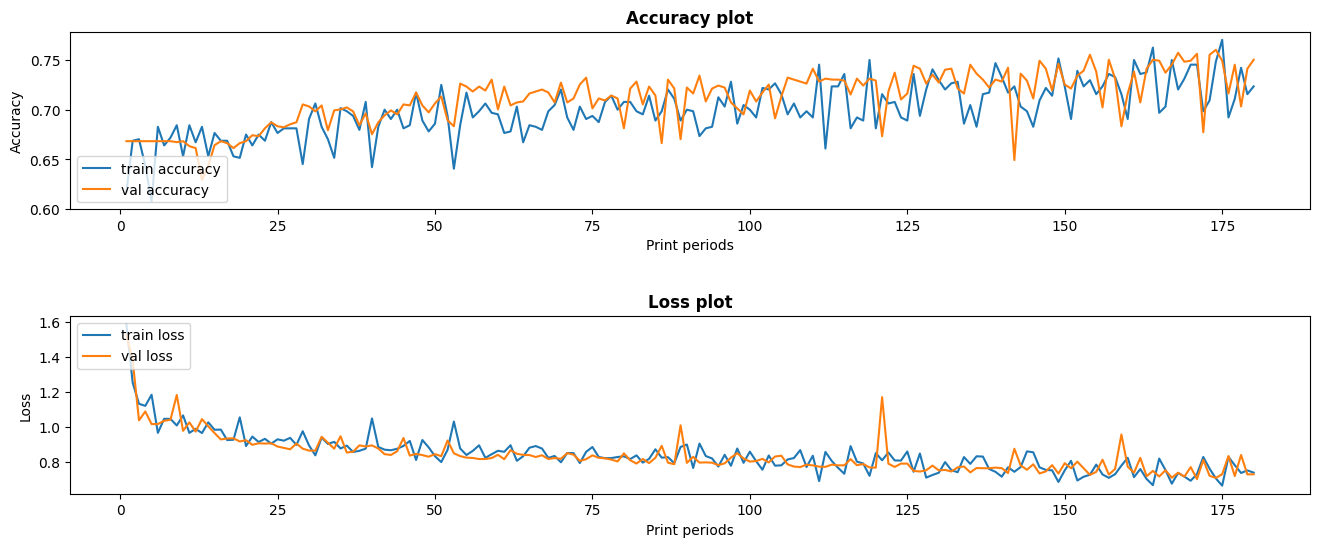

In [29]:
# Create x axis based on the number of print periods
x = [x for x in range(1,len(loss_development_train) + 1)]

# Set figure size
plt.figure(figsize=(16, 6))

# Plot accuracy lines subplot
plt.subplot(2,1,1)
plt.plot(x, accuracy_development_train, label = "train accuracy")
plt.plot(x, accuracy_development_val, label = "val accuracy")
plt.title("Accuracy plot", weight='bold')
plt.xlabel('Print periods')
plt.ylabel('Accuracy')
plt.legend(loc="lower left")

# Plot loss lines subplot
plt.subplot(2,1,2)
plt.plot(x, loss_development_train, label = "train loss")
plt.plot(x, loss_development_val, label = "val loss")
plt.title("Loss plot", weight='bold')
plt.xlabel('Print periods')
plt.ylabel('Loss')
plt.legend(loc="upper left")
# Adjust horizontal sapce between subplots
plt.subplots_adjust(hspace=0.6)

plt.show()

In [30]:
# Test the model on the testing data
num_images, testing_acc, testing_loss, preds, y_true = test_net(model=net, testloader=testloader, loss=loss, device=device)

In [31]:
# Print testing accuracy
print(f"Test accuracy in {num_images} images: {testing_acc:5f}")

# Print testing loss
print(f'Testing loss: {testing_loss:.5f}')

Test accuracy in 3004 images: 0.736019
Testing loss: 0.70320


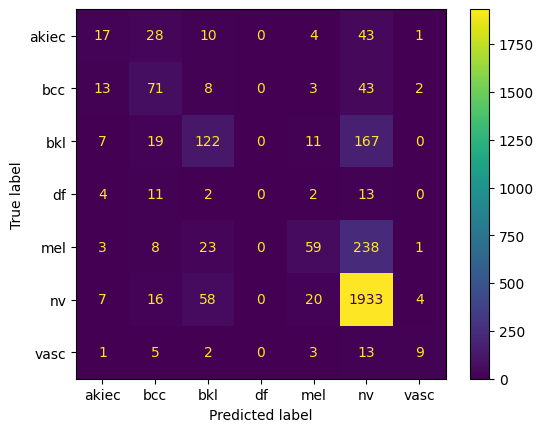

In [32]:
# Print confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']) 
cm_display.plot()
plt.show()

In [33]:
"""Notes for plotting confusion matrix with correct label order"""
# 5 = nv
# 1 = bcc
# 4 = mel
# 0 = akiec
# 2 = bkl
# 3 = df
# 6 = vasc

'Notes for plotting confusion matrix with correct label order'

# Complex convolutional network

In [34]:
# Create complex CNN model
class ComplexConv(nn.Module):
    """Complex convolutional neural network"""
    def __init__(self):
        super().__init__()
        # Create 5 convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.conv5 = nn.Conv2d(256, 512, 3)
        # Create 5 batch normalization layers
        self.norm1 = nn.BatchNorm2d(num_features=32)
        self.norm2 = nn.BatchNorm2d(num_features=64)
        self.norm3 = nn.BatchNorm2d(num_features=128)
        self.norm4 = nn.BatchNorm2d(num_features=256)
        self.norm5 = nn.BatchNorm2d(num_features=512)
        # Create pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Create last linear
        self.fc = nn.Linear(512, 7)

    def forward(self, x):
        # Pass images through all convolutional, relu, normalization and pooling layers
        x = self.pool(self.norm1(F.relu(self.conv1(x))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = self.pool(self.norm3(F.relu(self.conv3(x))))
        x = self.pool(self.norm4(F.relu(self.conv4(x))))
        x = self.pool(self.norm5(F.relu(self.conv5(x))))
        # Pass output of previous layers from global average pooling
        x = F.adaptive_avg_pool2d(input=x, output_size=(1, 1))
        # Flatten results from previous layers
        x = torch.flatten(x, 1)
        # Pass results through the linear layer
        x = self.fc(x)
        # Return data passed through all layers
        return x
    


In [35]:
# Create transform
transform = nn.Sequential(
    torchvision.transforms.Resize((100, 125), antialias=True),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
)
# Initialize dataset object
dataset = MLProject2Dataset(data_dir='/home/andrew/Documents/HUA/ML/2nd_assignment/dermoscopy_classification', transform=transform)
# Initialize generator with manual seed equal to 42 for reproducability
generator = torch.Generator().manual_seed(42)
# Split data into training,validation and testing parts
training, validation, testing = torch.utils.data.random_split(dataset, [0.6, 0.1, 0.3], generator=generator)
# rest, training, validation, testing = torch.utils.data.random_split(dataset, [0.8, 0.12, 0.02, 0.06], generator=generator)

# Set batch size
BATCH_SIZE = 128
# Create dataloaders for the data splits
trainloader = DataLoader(training, batch_size=BATCH_SIZE,
                         shuffle=True)
valloader = DataLoader(validation, batch_size=BATCH_SIZE,
                        shuffle=False)

testloader = DataLoader(testing, batch_size=BATCH_SIZE,
                        shuffle=False)
# Set device
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
# Initialize complex CNN model 
net = ComplexConv().to(device)
# Set loss function
loss = nn.CrossEntropyLoss()
# Set optimizer and learning rate
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [36]:
# Train and evaluate the model
accuracy_development_train, accuracy_development_val, loss_development_train, loss_development_val = train_net(
    model=net, trainloader=trainloader, valloader=valloader, epochs=20, optimizer=optimizer, loss=loss, device=device, print_period=5)

[Epoch: 0, batch:     4] training loss: 1.85970
Training accuracy in 640 images: 0.446875
[Epoch: 0] validation loss: 1.04968
Validation accuracy in 1001 images: 0.668332


[Epoch: 0, batch:     9] training loss: 1.07360
Training accuracy in 640 images: 0.621875
[Epoch: 0] validation loss: 0.96536
Validation accuracy in 1001 images: 0.664336


[Epoch: 0, batch:    14] training loss: 0.96737
Training accuracy in 640 images: 0.673438
[Epoch: 0] validation loss: 0.92545
Validation accuracy in 1001 images: 0.703297


[Epoch: 0, batch:    19] training loss: 0.91365
Training accuracy in 640 images: 0.681250
[Epoch: 0] validation loss: 0.84197
Validation accuracy in 1001 images: 0.681319


[Epoch: 0, batch:    24] training loss: 0.86244
Training accuracy in 640 images: 0.671875
[Epoch: 0] validation loss: 0.81308
Validation accuracy in 1001 images: 0.709291


[Epoch: 0, batch:    29] training loss: 0.86832
Training accuracy in 640 images: 0.700000
[Epoch: 0] validation loss: 0.77630
Validatio

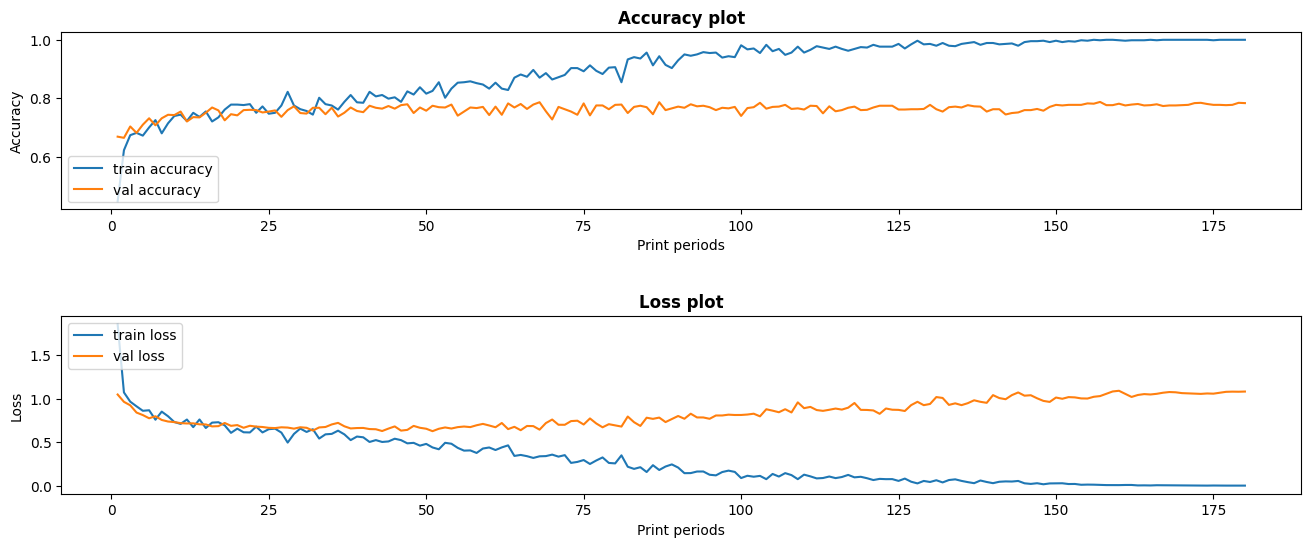

In [37]:
# Create x axis based on the number of print periods
x = [x for x in range(1,len(loss_development_train) + 1)]

# Set figure size
plt.figure(figsize=(16, 6))

# Plot accuracy lines subplot
plt.subplot(2,1,1)
plt.plot(x, accuracy_development_train, label = "train accuracy")
plt.plot(x, accuracy_development_val, label = "val accuracy")
plt.title("Accuracy plot", weight='bold')
plt.xlabel('Print periods')
plt.ylabel('Accuracy')
plt.legend(loc="lower left")

# Plot loss lines subplot
plt.subplot(2,1,2)
plt.plot(x, loss_development_train, label = "train loss")
plt.plot(x, loss_development_val, label = "val loss")
plt.title("Loss plot", weight='bold')
plt.xlabel('Print periods')
plt.ylabel('Loss')
plt.legend(loc="upper left")
# Adjust horizontal sapce between subplots
plt.subplots_adjust(hspace=0.6)

plt.show()

In [38]:
# Test the model on the testing data
num_images, testing_acc, testing_loss, preds, y_true = test_net(model=net, testloader=testloader, loss=loss, device=device)

In [39]:
# Print testing accuracy
print(f"Test accuracy in {num_images} images: {testing_acc:5f}")

# Print testing loss
print(f'Testing loss: {testing_loss:.5f}')

Test accuracy in 3004 images: 0.790613
Testing loss: 0.97083


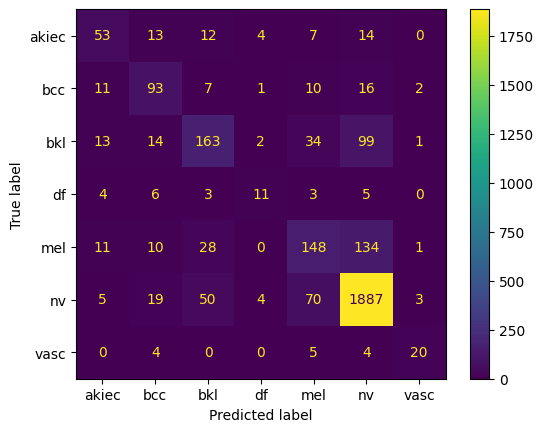

In [40]:
# Print confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']) 
cm_display.plot()
plt.show()

# Resnet34

In [6]:
# Create transform dictionary
data_transforms = {
    'train': transforms.Compose([
    transforms.RandomResizedCrop(224, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Create generator
generator = torch.Generator().manual_seed(42)
# Initialize dataset with transform for training data
dataset = MLProject2Dataset(data_dir='/home/andrew/Documents/HUA/ML/2nd_assignment/dermoscopy_classification', transform=data_transforms['train'])
# Get training split
training_valid, validation, testing = torch.utils.data.random_split(dataset, [0.6, 0.1, 0.3], generator=generator)
# Initialize dataset with transform for validation and testing data
dataset = MLProject2Dataset(data_dir='/home/andrew/Documents/HUA/ML/2nd_assignment/dermoscopy_classification', transform=data_transforms['val'])
# Get validation and testing split
training, validation_valid, testing_valid = torch.utils.data.random_split(dataset, [0.6, 0.1, 0.3], generator=generator)

# Set batch size
BATCH_SIZE = 32
# Initialize dataloaders
trainloader = DataLoader(training_valid, batch_size=BATCH_SIZE,
                         shuffle=False)
valloader = DataLoader(validation_valid, batch_size=BATCH_SIZE,
                        shuffle=False)

testloader = DataLoader(testing_valid, batch_size=BATCH_SIZE,
                        shuffle=False)
# Get device
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
# Initialize pre-trained resnet34 model
net = torchvision.models.resnet34(weights='DEFAULT').to(device)
# Set loss function
loss = nn.CrossEntropyLoss()
# Set optimizer, learning rate and momentum
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [7]:
# Train and evaluate the model
accuracy_development_train, accuracy_development_val, loss_development_train, loss_development_val = train_net(
    model=net, trainloader=trainloader, valloader=valloader, epochs=5, optimizer=optimizer, loss=loss, device=device, print_period=20)

[Epoch: 0, batch:    19] training loss: 4.36578
Training accuracy in 640 images: 0.421875
[Epoch: 0] validation loss: 1.79940
Validation accuracy in 1001 images: 0.650350


[Epoch: 0, batch:    39] training loss: 1.36653
Training accuracy in 640 images: 0.670312
[Epoch: 0] validation loss: 1.04185
Validation accuracy in 1001 images: 0.674326


[Epoch: 0, batch:    59] training loss: 1.07427
Training accuracy in 640 images: 0.685937
[Epoch: 0] validation loss: 0.92631
Validation accuracy in 1001 images: 0.686314


[Epoch: 0, batch:    79] training loss: 0.95997
Training accuracy in 640 images: 0.690625
[Epoch: 0] validation loss: 0.82222
Validation accuracy in 1001 images: 0.703297


[Epoch: 0, batch:    99] training loss: 0.94792
Training accuracy in 640 images: 0.679688
[Epoch: 0] validation loss: 0.79017
Validation accuracy in 1001 images: 0.727273


[Epoch: 0, batch:   119] training loss: 0.83936
Training accuracy in 640 images: 0.718750
[Epoch: 0] validation loss: 0.77211
Validatio

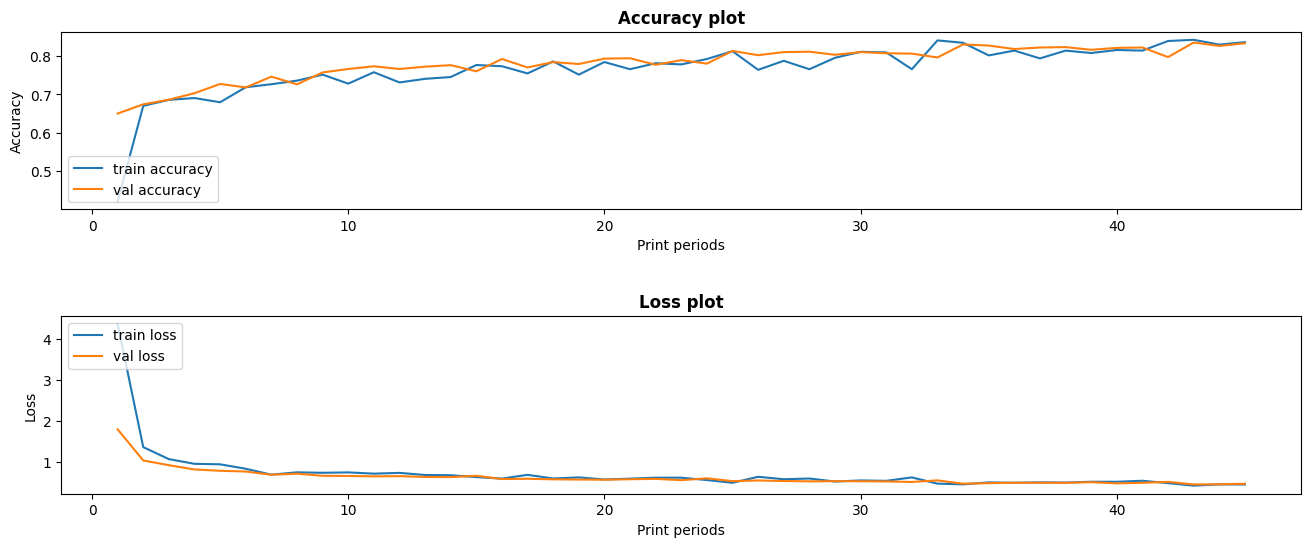

In [8]:
# Create x axis based on the number of print periods
x = [x for x in range(1,len(loss_development_train) + 1)]

# Set figure size
plt.figure(figsize=(16, 6))

# Plot accuracy lines subplot
plt.subplot(2,1,1)
plt.plot(x, accuracy_development_train, label = "train accuracy")
plt.plot(x, accuracy_development_val, label = "val accuracy")
plt.title("Accuracy plot", weight='bold')
plt.xlabel('Print periods')
plt.ylabel('Accuracy')
plt.legend(loc="lower left")

# Plot loss lines subplot
plt.subplot(2,1,2)
plt.plot(x, loss_development_train, label = "train loss")
plt.plot(x, loss_development_val, label = "val loss")
plt.title("Loss plot", weight='bold')
plt.xlabel('Print periods')
plt.ylabel('Loss')
plt.legend(loc="upper left")
# Adjust horizontal sapce between subplots
plt.subplots_adjust(hspace=0.6)

plt.show()

In [9]:
# Test the model on the testing data
num_images, testing_acc, testing_loss, preds, y_true = test_net(model=net, testloader=testloader, loss=loss, device=device)

In [10]:
# Print testing accuracy
print(f"Test accuracy in {num_images} images: {testing_acc:5f}")

# Print testing loss
print(f'Testing loss: {testing_loss:.5f}')

Test accuracy in 3004 images: 0.859188
Testing loss: 0.39354


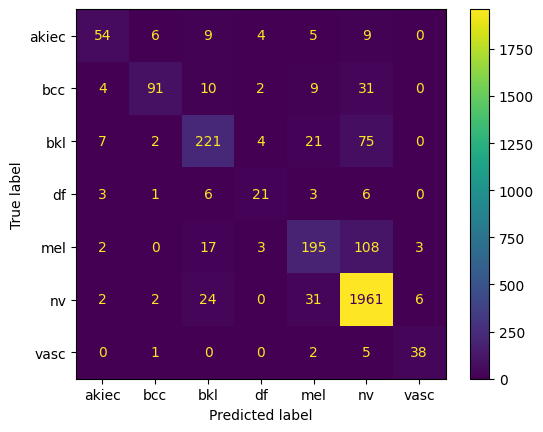

In [11]:
# Print confusion matrix
confusion_matrix = metrics.confusion_matrix(y_true, preds)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'])
cm_display.plot()
plt.show()